#### Quick look at the data

In [3]:
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import geopandas
import gsw
import pandas as pd
import pyproj
import psutil

import functions
import saildrone_processing

In [4]:
plt.rc('font', size=12)

### Load in altimetry data

In [8]:
adt = functions.import_cmems('adt', 
      'https://my.cmems-du.eu/thredds/dodsC/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D', 
      'mjakes', 'ohw_22_MJ', -180, 180, -65, -45, '2019-01-01', '2019-03-01')

### Saildrone data

Circumpolar track around the Southern Ocean from 2019.

In [4]:
ds_saildrone = xr.open_mfdataset("~/shared/antarctic_sd_data/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1620360815446.nc", chunks='auto')

In [5]:
# subset of variables from the dataset
variables = [
    'TEMP_CTD_RBR_STDDEV',
    'TEMP_CTD_RBR_MEAN',
    'SAL_RBR_MEAN',
    'SAL_RBR_STDDEV',
    'O2_CONC_AANDERAA_MEAN',
    'O2_CONC_AANDERAA_STDDEV',
    'CHLOR_RBR_MEAN',
    'CHLOR_RBR_STDDEV']

df = saildrone_processing.prepare_data(ds_saildrone, variables, aggregate_method='mean')

In [6]:
distance = functions.distFromStart(df.latitude.values, df.longitude.values)
df['distance_km'] = distance

In [9]:
mean_sea_level = adt.mean(dim = 'time')

In [10]:
adt_levels = np.arange(-1.5,1,0.25)

(-180.0, 180.0)

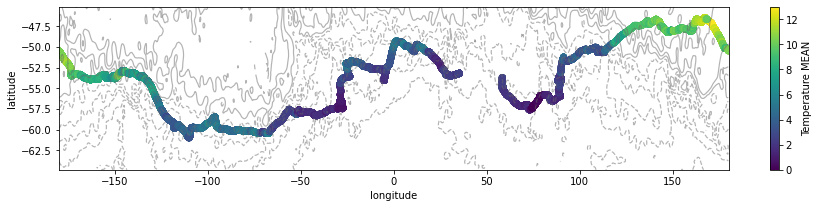

In [61]:
fig, ax = plt.subplots(figsize = (15,3))
plt.scatter(df.longitude, df.latitude, c = df.TEMP_CTD_RBR_MEAN, vmin = 0, vmax = 13)

CS = mean_sea_level.plot.contour(colors = 'dimgrey', alpha = 0.5, linewidths = 1.2, levels = adt_levels)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label = 'Temperature MEAN')

plt.xlim(-180,180)

# TO DO: bin the ADT values into longitude (and time) bins so that the ADT contours on the map show the mean ADT during that part of the saildrone trajectory

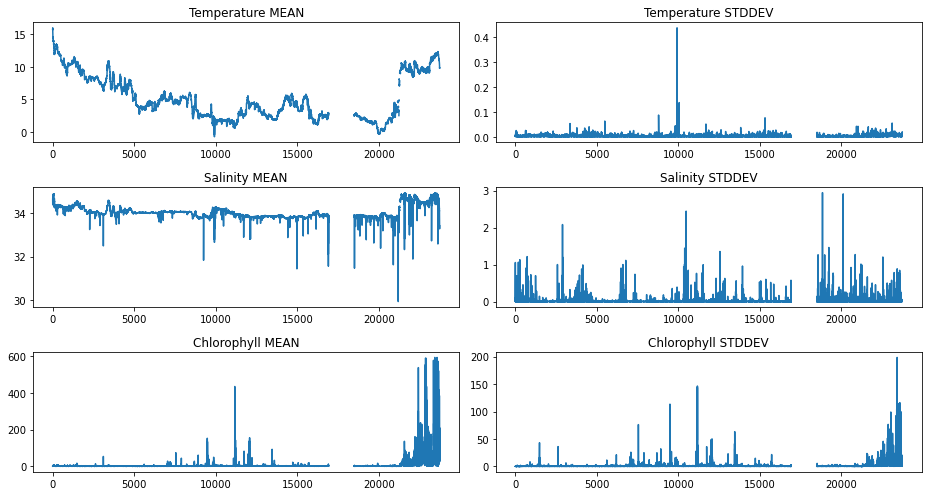

In [22]:
# Some timeseries plots to have a look at the data 
x = df.time
x = df.distance_km

fig, axs = plt.subplots(3, 2, figsize = (13,7))
axs = axs.flatten()

axs[0].plot(x, df.TEMP_CTD_RBR_MEAN)
axs[0].set_title('Temperature MEAN')

axs[1].plot(x, df.TEMP_CTD_RBR_STDDEV)
axs[1].set_title('Temperature STDDEV')

axs[2].plot(x, df.SAL_RBR_MEAN)
axs[2].set_title('Salinity MEAN')

axs[3].plot(x, df.SAL_RBR_STDDEV)
axs[3].set_title('Salinity STDDEV')

axs[4].plot(x, df.CHLOR_RBR_MEAN)
axs[4].set_title('Chlorophyll MEAN')

axs[5].plot(x, df.CHLOR_RBR_STDDEV)
axs[5].set_title('Chlorophyll STDDEV')

plt.tight_layout(h_pad = 1.2)

### ADCP data

In [5]:
adcp = xr.open_dataset('~/shared/antarctic_sd_data/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1597092482498.nc')

In [4]:
# TO DO: ADCP processing - resample to every 5 minutes to match the saildrone data (use ffill?)

In [6]:
adcp_vars = [
    'vel_east',
    'vel_north',
    'vel_up']

ds_adcp = adcp[adcp_vars].isel(trajectory = 0)

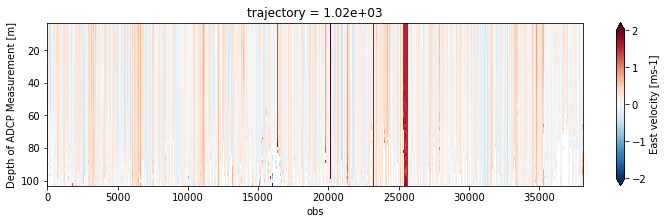

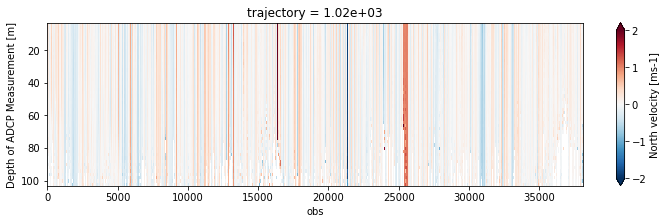

In [6]:
fig, ax = plt.subplots(figsize = (12,3))
ds_adcp.vel_east.plot(x = 'obs', vmin = -2, vmax = 2, cmap = 'RdBu_r')
ax.invert_yaxis()

fig, ax = plt.subplots(figsize = (12,3))
ds_adcp.vel_north.plot(x = 'obs', vmin = -2, vmax = 2, cmap = 'RdBu_r')
ax.invert_yaxis()

In [19]:
lons = ds_adcp.longitude
lats = ds_adcp.latitude
u = ds_adcp.vel_east
v = ds_adcp.vel_north

In [20]:
def stream_bearing(lons, lats):
    bearing = []
    for i in range(0, len(lats)-1):
        lat1, lat2 = lats[i], lats[i+1]
        lon1, lon2 = lons[i], lons[i+1]
        
        # WGS84 is the reference coordinate system (Earth's centre of mass) used by GPS.
        geodesic = pyproj.Geod(ellps='WGS84')  
        # Inverse computation to calculate the forward azimuths from two lat and lon coordinates. 
        fwd_azimuth = geodesic.inv(lon1, lat1, lon2, lat2)[0]

        # if the angle is negative (anticlockwise from N), add it to 360 to get the bearing clockwise from N.
        if fwd_azimuth < 0:
            fwd_azimuth = 360 + fwd_azimuth
            
        bearing.append(fwd_azimuth)
        
    return np.asarray(bearing)

In [10]:
along_strm_brng = stream_bearing(lons, lats)

In [ ]:
velocity_brng = uv_bearing(u, v)

In [34]:
angle_rad = np.deg2rad(along_strm_brng)
y = 0.3 * np.cos(angle_rad) 
x = 0.3 * np.sin(angle_rad) 

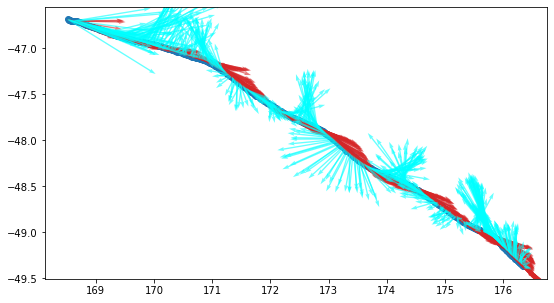

In [41]:
fig, ax = plt.subplots(figsize = (9,5))
plt.scatter(lons, lats)
plt.quiver(lons[:-1], lats[:-1], x, y, color = 'tab:red', scale = 3, alpha = 0.6)
plt.quiver(lons, lats, u.mean(dim = 'cell_depth'), v.mean(dim = 'cell_depth'),  color = 'cyan', scale = 3, alpha = 0.6)

In [21]:
def uv_bearing(u, v):
    '''calculates the bearing from N using values of u and v'''
    theta = np.rad2deg(np.arctan2(u, v))
    theta += 360
    theta = theta % 360
    return theta

In [22]:
def rotate_vels(u, v, lons, lats):
    # remove the last observation because 
    speed = np.sqrt(u**2 + v**2)[:-1]
    velocity_bearing = uv_bearing(u, v)[:-1]

    along_strm_brng = stream_bearing(lons, lats)
    # make 1D array into 2D in the same shape as velocity bearings
    along_strm_brng = np.tile(along_strm_brng,(len(u[0]), 1)).transpose()

    # find the angle between the velocity bearing and the along stream direction
    theta = along_strm_brng - velocity_bearing

    # calculate u and v using this new angle (converting degrees to radians)
    u_rot = np.cos(theta*np.pi/180)*speed
    v_rot = np.sin(theta*np.pi/180)*speed
    
    return u_rot, v_rot

In [23]:
u_rot, v_rot = rotate_vels(u, v, lons, lats)

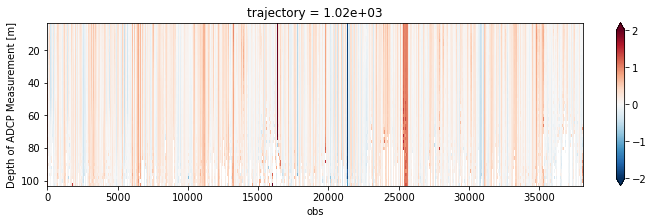

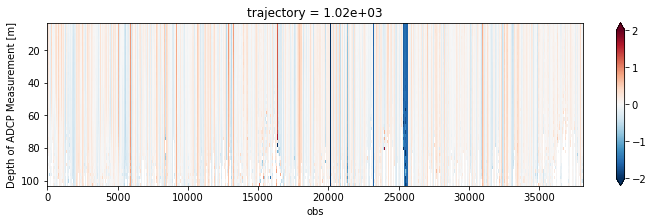

In [24]:
fig, ax = plt.subplots(figsize = (12,3))
u_rot.plot(x = 'obs', vmin = -2, vmax = 2, cmap = 'RdBu_r')
ax.invert_yaxis()

fig, ax = plt.subplots(figsize = (12,3))
v_rot.plot(x = 'obs', vmin = -2, vmax = 2, cmap = 'RdBu_r')
ax.invert_yaxis()

In [109]:
# ds_adcp.assign_coords(distance_km = (('distance'), distance))

## Front detection

In [55]:
def detect_fronts(df, var, criterion, x = 'distance_km', x_bin = 20):
    
    df['dx'] = np.abs(np.gradient(df[x]))
    df['d_var'] = np.abs(np.gradient(df[var]))
    
    df_new = df[[var, 'latitude', 'longitude', x, 'dx', 'd_var']]
    
    # group into 20 km segments
    df_grouped = df_new.groupby(df_new[x] // x_bin)
    
    # apply minimum observations function
    # returns nan is there are < 10 observations else computes the mean of the group
    df_group_mean = df_grouped.apply(minimum_obs)
    
    # calculate gradient of var with distance
    df_group_mean['d_var_dx'] = np.round(df_group_mean['d_var'], 3)/df_group_mean['dx']
    
    # front detection criteria
    criterion = [-np.inf] + criterion + [np.inf]
    
    df_group_mean['level'] = pd.cut(df_group_mean['d_var_dx'], criterion, labels = False)
    
    return df_group_mean


In [80]:
def minimum_obs(group):
    if len(group) < 10:
        return np.nan
    else:
        return group.mean()

In [90]:
# input the data variable that you want to find fronts with
var = 'TEMP_CTD_RBR_MEAN'

# TO DO: Discuss what criterion we should use for different variables.
criterion = [0.01, 0.05, 0.25, 0.75, 1] 

temp_fronts = detect_fronts(df, var, criterion)

(-180.0, 180.0)

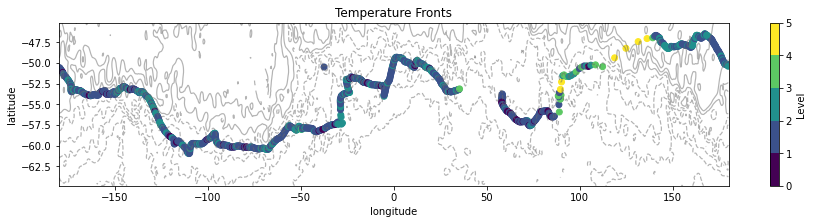

In [91]:
fig, ax = plt.subplots(figsize = (15,3))

cmap = plt.cm.viridis
norm = mpl.colors.BoundaryNorm(np.arange(0, len(criterion)+1, 1), cmap.N)

plt.scatter(fronts.longitude, fronts.latitude, c = fronts.level, norm = norm)

CS = mean_sea_level.plot.contour(colors = 'dimgrey', alpha = 0.5, linewidths = 1.2, levels = adt_levels)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label = 'Level', ticks = np.arange(0, len(criterion)+1, 1))
plt.title('Temperature Fronts')
plt.xlim(-180,180)